In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('price_list_address.csv')
df.drop(columns='Unnamed: 0', inplace=True)

상위 10개 건설사는 1로, 상위 5개 건설사는 2로 매핑합니다.

In [ ]:

#encoding='cp949'
#최근 3년간 시공능력 순위 Top5 건설사: 삼성물산,현대건설,대우건설,현대엔지니어링,GS,DL이엔씨,포스코
major2 = ['자이','힐스테이트','디에이치','현대','편한세상','아크로','더샵','오티에르','래미안','삼성','푸르지오']
#Top 10 건설사 : 롯데건설, SK,한화,HDC
major1 = ['롯데','르엘','아이파크','드파인','아펠바움','SK','호반','포레나','꿈에그린','오벨리스크']
df['major']=0 #0으로 초기화
for i in range(len(df)):
    if any(substring in df.loc[i, 'Name'] for substring in major1):
        df.loc[i, 'major'] = 1
        print(1)
    if any(substring in df.loc[i, 'Name'] for substring in major2):
        df.loc[i, 'major'] = 2

In [3]:
df2= df[['Longitude',
       'Latitude', 'major', 'Building Year', 'Floor', 'Actual Price Index',
       'Living Price Index', 'Interest Rate', 'Jeonse Index','Total Population',
       'Children', 'Adolescent', 'Youth', 'Middle-Aged', 'Old Age',
       'Consumption','Area','Price']]

종속변수와 독립변수의 상관관계를 확인합니다.

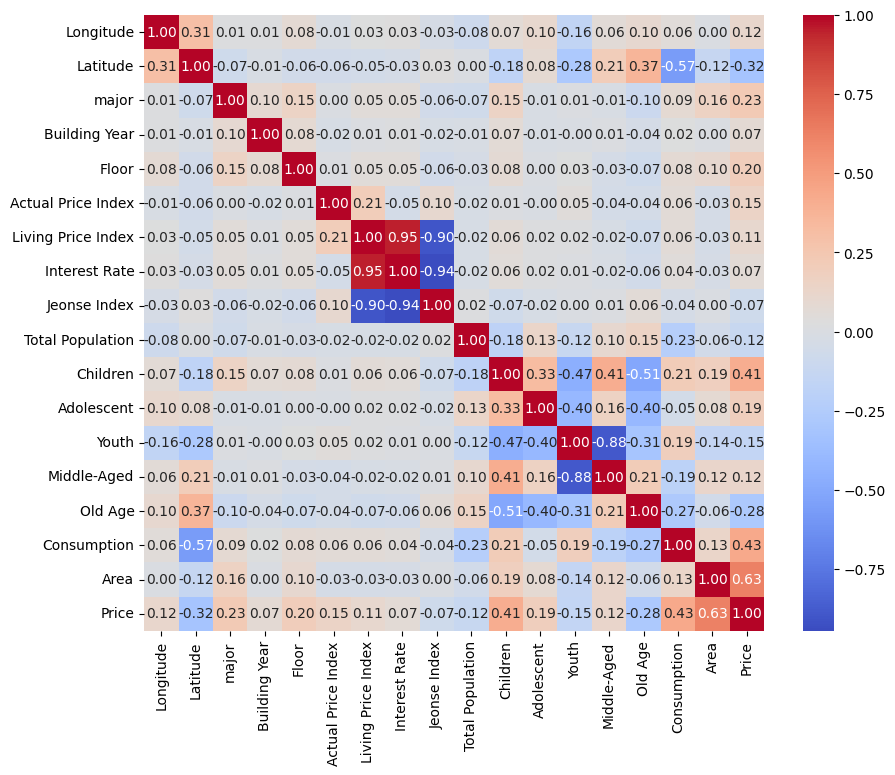

In [4]:
corr_matrix = df2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [5]:
df['Price per Area'] = df['Price']/df['Area']

Area(면적)의 상관관계가 너무 높아, 다른 변수의 학습이 원할하지 않을것을 우려하여 면적당 가격으로 타켓변수를 변형합니다.

In [6]:
df3 =df[['Longitude',
       'Latitude', 'major', 'Building Year', 'Floor', 'Actual Price Index',
       'Living Price Index', 'Interest Rate', 'Jeonse Index','Total Population',
       'Children', 'Adolescent', 'Youth', 'Middle-Aged', 'Old Age',
       'Consumption','Price per Area']]

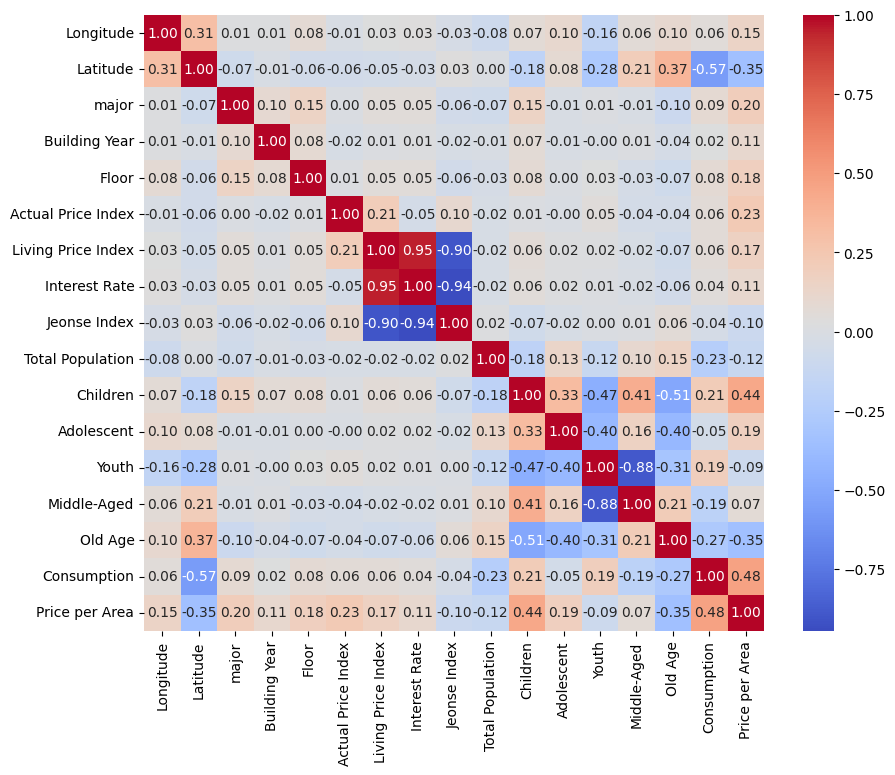

In [7]:
corr_matrix2 = df3.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
괜찮게 나왔습니다.

In [8]:
station = pd.read_csv('station.csv', encoding='utf-8')
school = pd.read_csv('school.csv', encoding='utf-8')
hospital = pd.read_csv('Hospital.csv', encoding='cp949')
facility = pd.read_csv('facility.csv', encoding='cp949')
bridge = pd.read_csv('bridge.csv', encoding='utf-8')
bus = pd.read_csv('bus.csv', encoding='cp949')

In [9]:
medical_center = hospital[hospital['병원분류명'] == '종합병원']
hospital = hospital[hospital['병원분류명'] != '종합병원']
elementary_school = school[school['학교종류명'] == '초등학교']
school = school[school['일반명문고'] == 'o']

LibMus = facility[(facility['시설용도분류'] == 'FU_BB') | (facility['시설용도분류'] == 'FU_BC')]
Mall = facility[facility['시설용도분류'] == 'FU_BA']
Hospital = facility[(facility['시설용도분류'] == 'FU_BD') | (facility['시설용도분류'] == 'FU_BE')| (facility['시설용도분류'] == 'FU_BH')| (facility['시설용도분류'] == 'FU_BG')]
Park = facility[(facility['시설용도분류'] == 'FU_BI') | (facility['시설용도분류'] == 'FU_BJ')]

적절하게 데이터를 변형해 줍니다.

한강 다리의 좌표를 찍은 bridge.csv는 다음과 같습니다.

In [10]:
import folium

m = folium.Map(location=[bridge.iloc[0]['Latitude'], bridge.iloc[0]['Longitude']], zoom_start=13)

for index, row in bridge.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(m)


In [11]:
from scipy.interpolate import interp1d

hangang_sorted = bridge.sort_values(by='Longitude')

# 다리를 찍을 좌표를 선형보간으로 잇습니다.
interpolate_lon = np.linspace(hangang_sorted['Longitude'].min(), hangang_sorted['Longitude'].max(), 130) #선 상에 있는 좌표를 기록합니다. 130개
linear_interp = interp1d(hangang_sorted['Longitude'], hangang_sorted['Latitude'], kind='linear')
interpolate_lat = linear_interp(interpolate_lon)

selected_coords = np.column_stack((interpolate_lon, interpolate_lat)) 

# 선택된 좌표를 담은 데이터프레임 생성
selected_coords_df = pd.DataFrame(selected_coords, columns=['Longitude', 'Latitude'])

이를 선상에 있는 좌표를 기록해서 아래와 같이 표시합니다.

In [12]:


m = folium.Map(location=[selected_coords_df.iloc[0]['Latitude'], selected_coords_df.iloc[0]['Longitude']], zoom_start=13)

# DataFrame의 각 위치에 대한 마커 추가
for index, row in selected_coords_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(m)

# 지도를 HTML 파일로 저장
m

In [13]:
def haversine(lat1, lon1, lat2, lon2): #Haversine 함수를 정의합니다. 
    
    #속도를 빠르게하기 위해 데이터프레임을 직접 사용하지않고 넘파이 어레이를 사용했습니다.
    lat1, lon1, lat2, lon2 = map(np.radians, [np.array(x).astype(float) for x in [lat1, lon1, lat2, lon2]]) 
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = 6371 * c # 6371 = 지구 반지름
    
    return distance

#가장 가까운 역의 이름과 그 거리를 기록하는 함수입니다.

def find_nearest_stations(df, station):

    #마찬가지로 넘파이 어레이로 변형합니다.
    lat1 = df['Latitude'].values[:, np.newaxis]
    lon1 = df['Longitude'].values[:, np.newaxis]
    lat2 = station['Latitude'].values
    lon2 = station['Longitude'].values

    distances = haversine(lat1, lon1, lat2, lon2)
    nearest_idx = np.argmin(distances, axis=1)
    nearest_stations = station.iloc[nearest_idx]
    
    # 가장 가까운 역의 이름과 거리를 DataFrame에 추가합니다.
    df['Nearest Station'] = nearest_stations['Station Name'].values
    df['Distance to NS'] = np.min(distances, axis=1)


#가장 가까운 종합병원의 이름과 그 거리를 기록하는 함수입니다.

def find_nearest_medical_centers(df, medical_center):

    lat1 = df['Latitude'].values[:, np.newaxis]
    lon1 = df['Longitude'].values[:, np.newaxis]
    lat2 = medical_center['Latitude'].values
    lon2 = medical_center['Longitude'].values

    distances = haversine(lat1, lon1, lat2, lon2)
    nearest_idx = np.argmin(distances, axis=1)
    nearest_medical_centers = medical_center.iloc[nearest_idx]
    
    df['Nearest Medical Center'] = nearest_medical_centers['기관명'].values
    df['Distance to MC'] = np.min(distances, axis=1)


find_nearest_medical_centers(df, medical_center)
find_nearest_stations(df, station)

In [14]:
#거리 안에 있는 초등학교를 세는 함수

def count_schools(apartment, school, km1):
    
    counts = []

    lat1 = apartment['Latitude'].values[:, np.newaxis]
    lon1 = apartment['Longitude'].values[:, np.newaxis]
    lat2 = school['Latitude'].values
    lon2 = school['Longitude'].values

    for i in range(len(lat1)):
        distances = haversine(lat1[i], lon1[i], lat2, lon2)

        count = np.sum(distances <= km1) #거리를 수정
        counts.append(count)

    return counts

#거리 안에 있는 고등학교를 세는 함수. 명문고등학교만을 포함합니다. 명문 고등학교는 일반고등학교 중에서 서울대 진학률 상위 50개 학교만 기록하엿습니다.

def count_high_schools(apartment, school, km2):
    
    counts = []

    lat1 = apartment['Latitude'].values[:, np.newaxis]
    lon1 = apartment['Longitude'].values[:, np.newaxis]
    lat2 = school['Latitude'].values
    lon2 = school['Longitude'].values

    for i in range(len(lat1)):
        distances = haversine(lat1[i], lon1[i], lat2, lon2)

        count = np.sum(distances <= km2 ) #거리를 수정
        counts.append(count)

    return counts

#거리 안에 있는 상업시설을 세는 함수

def count_market(apartment, market, km3):
    
    counts = []

    lat1 = apartment['Latitude'].values[:, np.newaxis]
    lon1 = apartment['Longitude'].values[:, np.newaxis]
    lat2 = market['Latitude'].values
    lon2 = market['Longitude'].values

    for i in range(len(lat1)):
        distances = haversine(lat1[i], lon1[i], lat2, lon2)
        count = np.sum(distances <= km3)
        counts.append(count)

    return counts

#거리 안에 있는 일반 병의원 수를 세는  함수

def count_hostipal(apartment, hostipal, km4):
    
    counts = []

    lat1 = apartment['Latitude'].values[:, np.newaxis]
    lon1 = apartment['Longitude'].values[:, np.newaxis]
    lat2 = hostipal['Latitude'].values
    lon2 = hostipal['Longitude'].values

    for i in range(len(lat1)):
        distances = haversine(lat1[i], lon1[i], lat2, lon2)
        count = np.sum(distances <= km4)
        counts.append(count)

    return counts

#거리안에 공원, 하천이 있다면 1을, 없다면 0을 반환하는 함수

def find_park(apartment, park, km5):
    
    counts = []

    lat1 = apartment['Latitude'].values[:, np.newaxis]
    lon1 = apartment['Longitude'].values[:, np.newaxis]
    lat2 = park['Latitude'].values
    lon2 = park['Longitude'].values

    for i in range(len(lat1)):
        distances = haversine(lat1[i], lon1[i], lat2, lon2)
        count = np.any(distances <= km5).astype(int)
        counts.append(count)

    return counts

#한강 중심으로 부터 정해진 거리만큼 떨어진 거리안에 있다면 1을, 아니면 0을 반환하는 함수

def find_hangang(apartment, hangang, km6):
    
    counts = []

    lat1 = apartment['Latitude'].values[:, np.newaxis]
    lon1 = apartment['Longitude'].values[:, np.newaxis]
    lat2 = hangang['Latitude'].values
    lon2 = hangang['Longitude'].values

    for i in range(len(lat1)):
        distances = haversine(lat1[i], lon1[i], lat2, lon2)
        count = np.any(distances <= km6).astype(int)
        counts.append(count)

    return counts

#km 수치는 지도를 확인하면서, 수치를 바꿔가면서 확인하였음

df['Elementary Schools Num'] = count_schools(df, elementary_school, 0.7)
df['High Schools Num'] = count_high_schools(df, school, 2)
df['Market Num'] = count_market(df, Mall, 1)
df['Hospital Num'] = count_hostipal(df, Hospital, 1)
df['Park Presence'] = find_park(df, Park, 0.8)
df['Nearby Hangang'] = find_hangang(df, selected_coords_df, 0.9)

In [15]:
from tqdm import tqdm #프로그레스바를 확인하는 라이브러리
import haversine
from haversine import Unit

#버스 정류장 데이터 수가 많아서 라이브러리를 불러오는것이 더 빠르기에, 라이브러리를 불러왔음.
#이유는 알 수 없지만, 위의 함수는 라이브러리를 쓰면 더 느려짐

def count_bus_stations(latitudes, longitudes, bus):
    counts = []
    
    # 각 아파트 위치에 대해 tqdm을 사용하여 진행 상태 표시
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc='Counting bus stations'):
        # 현재 아파트 위치 주변의 버스 정류장만 필터링
        # 데이터가 많아 시간을 줄이기 위함.
        # 위도 0.011 = 1km, 경도 0.007 = 1km
        nearby_bus = bus[((bus['Latitude'] >= lat - 0.02) & (bus['Latitude'] <= lat + 0.02)) &
                          ((bus['Longitude'] >= lon - 0.02) & (bus['Longitude'] <= lon + 0.02))]
        
        # 필터링된 버스 정류장들에 대해 거리 계산
        if not nearby_bus.empty:  # 필터링된 버스 정류장이 있을 경우에만 계산
            apartment_location = (lat, lon)
            bus_locations = [(x, y) for x, y in zip(nearby_bus['Latitude'], nearby_bus['Longitude'])]
            distances = [haversine.haversine(apartment_location, bus_loc, unit=Unit.KILOMETERS) for bus_loc in bus_locations]
            count = sum(distance <= 0.5 for distance in distances) / 2  # 버스 정류장이 양측에 있으므로 2로 나눕니다
            counts.append(count)
        else:
            counts.append(0)  # 주변에 버스 정류장이 없는 경우
    
    return counts


df['Bus Station'] = count_bus_stations(df['Latitude'].values, df['Longitude'].values, bus)


Counting bus stations: 100%|██████████| 203663/203663 [02:55<00:00, 1162.61it/s]


In [17]:
df.to_csv('price_list_data.csv')